In [ ]:
# import to load dataset
import os
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.optim as optim
from numba import cuda
use_cuda = torch.cuda.is_available()
import torchvision.transforms as T
import torchvision.datasets as D
import random
from torch.utils.data import Subset

In [ ]:
# import the dataset
from google.colab import drive
drive.mount('/content/drive')

import os

small_dataset = ['CNV', 'DME', 'Drusen', 'Normal']
small_dataset_dir = '/content/drive/MyDrive/APS360 Project - Group 7/Code/small_dataset'
#'/content/drive/MyDrive/UofT/Third Year/Summer/APS360/APS360 Project - Group 7/Code/small_dataset' ## change this based on your own google drive directory

def num_images(dir, folders):
    print(f"Number of images in each folder:")
    for folder in folders:
        path = os.path.join(dir, folder)
        if os.path.isdir(path):
            num_files = len(os.listdir(path))
            print(f"{folder}: {num_files}")
        else:
            print(f"Folder '{folder}' does not exist in the dataset directory.")

num_images(small_dataset_dir, small_dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of images in each folder:
CNV: 50
DME: 50
Drusen: 50
Normal: 50


In [ ]:
# import to load dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import torch

transform = T.ToTensor()
dataset = ImageFolder(root=small_dataset_dir, transform=transform)

# split the data: 70% training, 15% validation, 15% testing
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len
train_data, val_data, test_data = random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))

# define dataloader parameters
batch_size = 32

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# check the number of training, validation, and test images alongside the percentage of training, validation, and testing (check)
print(f"Number of training images: {len(train_data)}  Percent: {100 * len(train_data)/total_len:.2f}")
print(f"Number of validation images: {len(val_data)}  Percent: {100 * len(val_data)/total_len:.2f}")
print(f"Number of test images: {len(test_data)}  Percent: {100 * len(test_data)/total_len:.2f}")

Number of training images: 140  Percent: 70.00
Number of validation images: 30  Percent: 15.00
Number of test images: 30  Percent: 15.00


In [ ]:
# create CNN model
class EyeDentify(nn.Module):
    def __init__(self):
        super(EyeDentify, self).__init__()
        self.name = "eyedentify"
        self.conv1 = nn.Conv2d(3, 5, 5) # rgb
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 128)
        self.fc2 = nn.Linear(128, 4) # 4 classes (normal, drusen, DME, CNV)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        # select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, train_data, val_data, batch_size=64, learning_rate = 0.001, num_epochs=20):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1

        print(f"Epoch {epoch+1}: Train acc: {train_acc[-1]:.4f} | Validation acc: {val_acc[-1]:.4f}")
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.3286 | Validation acc: 0.2000
Epoch 2: Train acc: 0.2571 | Validation acc: 0.2333
Epoch 3: Train acc: 0.4286 | Validation acc: 0.3000
Epoch 4: Train acc: 0.4071 | Validation acc: 0.2667
Epoch 5: Train acc: 0.4786 | Validation acc: 0.2667
Epoch 6: Train acc: 0.5786 | Validation acc: 0.3333
Epoch 7: Train acc: 0.6500 | Validation acc: 0.3667
Epoch 8: Train acc: 0.6429 | Validation acc: 0.3000
Epoch 9: Train acc: 0.7000 | Validation acc: 0.3667
Epoch 10: Train acc: 0.7357 | Validation acc: 0.4000
Epoch 11: Train acc: 0.7786 | Validation acc: 0.4333
Epoch 12: Train acc: 0.8143 | Validation acc: 0.4667
Epoch 13: Train acc: 0.8500 | Validation acc: 0.4667
Epoch 14: Train acc: 0.8571 | Validation acc: 0.5000
Epoch 15: Train acc: 0.9143 | Validation acc: 0.5000


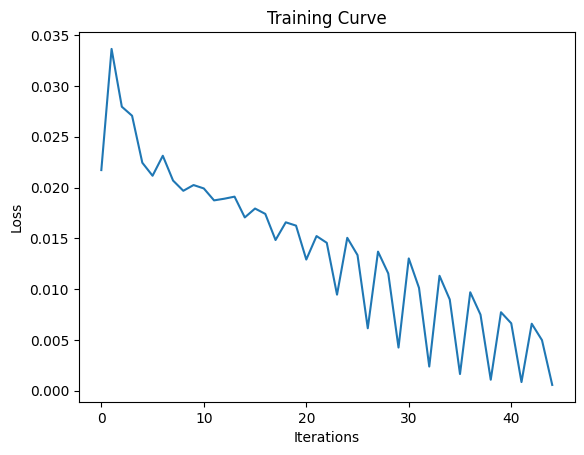

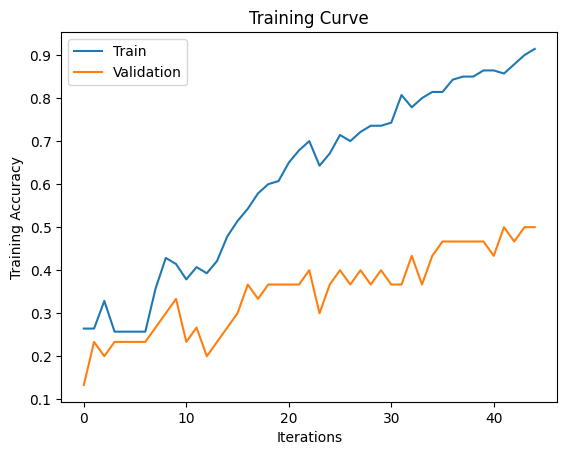

Final Training Accuracy: 0.9142857142857143
Final Validation Accuracy: 0.5


In [ ]:
use_cuda = True

model = EyeDentify()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

train(model, train_data, val_data, batch_size=64, num_epochs=15)

In [ ]:
# compute the test accuracy
test_acc = get_accuracy(model, test_loader)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.6000


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
def plot_confusion_matrix(model, data_loader, class_names):
    # set model into evaluation mode
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            output = model(imgs)
            preds = output.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

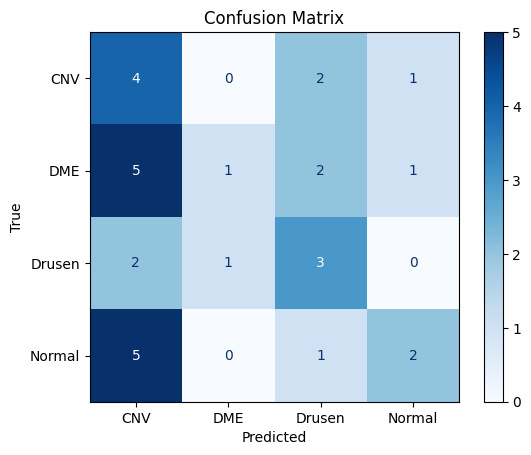

array([[4, 0, 2, 1],
       [5, 1, 2, 1],
       [2, 1, 3, 0],
       [5, 0, 1, 2]])

In [ ]:
class_names = ['CNV', 'DME', 'Drusen', 'Normal']
plot_confusion_matrix(model, test_loader, class_names)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# plot roc curve
def plot_roc_curve(model, data_loader, class_names):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            output = model(imgs)
            probs = torch.softmax(output, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # binarize the labels for multi-class ROC
    y_true = label_binarize(all_labels, classes=np.arange(len(class_names)))
    n_classes = y_true.shape[1]

    # compute ROC and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plot the ROC curve
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # random classfier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc

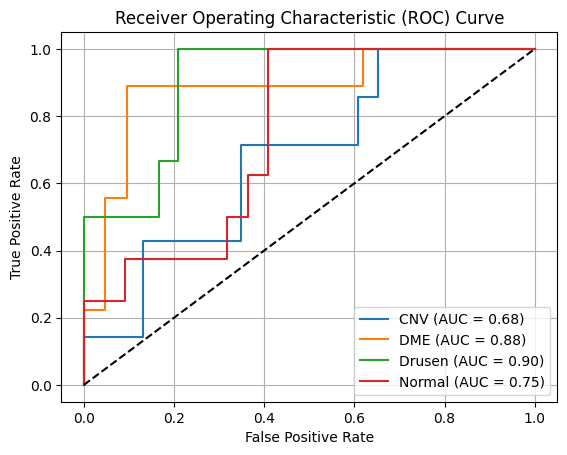

In [ ]:
roc_auc = plot_roc_curve(model, test_loader, class_names)